### Chain using LangGraph

In this section, we will see how we can build a simple chain using Langgraph that uses 4 important concepts

- How to use chat messages as our graph state
- How to use chat models in graph nodes
- How to bind tools to our LLM in chat models
- How to execute the tools call in our graph nodes

In [2]:
from dotenv import load_dotenv
load_dotenv()

import os
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")

### How to use chat messages as our graph state

#### Messages

We can use messages which can be used to capture different roles within a conversation. LangChain has various message types including HumanMessage, AIMessage, SystemMessage and ToolMessage. These represent a message from the user, from chat model, for the chat model to instruct behavior, and from a tool call.

Every message have these important components.
- Content - content of the message
- Name - specify the name of author
- Response metadata - optionally, a dict of metadata (eg., often populated by model provider for AIMessages)



In [9]:
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage, ToolMessage
from pprint import pprint

messages = [
    HumanMessage(content="Hey, I'm Satya. I like cricket.", name="satya"),
    AIMessage(content="Hello, Satya. I like cricket too.", name = "LLMmodel"),
    HumanMessage(content="What other sports do you like?", name="satya"),
    AIMessage(content="I like football and basketball.", name = "LLMmodel"),
    HumanMessage(content="And what else?", name="satya"), 
]

for message in messages:
    message.pretty_print()

================================ Human Message =================================
Name: satya

Hey, I'm Satya. I like cricket.
================================== Ai Message ==================================
Name: LLMmodel

Hello, Satya. I like cricket too.
================================ Human Message =================================
Name: satya

What other sports do you like?
================================== Ai Message ==================================
Name: LLMmodel

I like football and basketball.
================================ Human Message =================================
Name: satya

And what else?


#### Chat models

We can use the sequence of message as input with the chatmodels using LLM's and OPENAI.


In [10]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-3.5-turbo", temperature=0)
llm.invoke(messages)


AIMessage(content='I also enjoy tennis and swimming. How about you? What other sports do you like?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 78, 'total_tokens': 96, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-BmDEu5FTeTGbmpDNEDjLci58RQoj6', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--27f79182-0ac9-4ae9-a20b-561d59a5eb2b-0', usage_metadata={'input_tokens': 78, 'output_tokens': 18, 'total_tokens': 96, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

#### Tools

Tols can be integrated with the LLM models to interact with external systems. External systems can be APIs and third party tools. 

Whenever a query is asked the model can choose to call the tool and this query is based on the natural language input and this will return an output that matches the tool's schema


In [12]:
def add(a: int, b: int):
    """ Add a and b
    Args:
        a: int
        b: int
    Returns:
        int
    """
    return a + b

In [14]:
#### Binding tool with llm

llm_with_tools = llm.bind_tools([add])

tool_call = llm_with_tools.invoke([HumanMessage(content="What is 10 + 20?", name = "satya")])

tool_call.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  add (call_QDFQ6A1illdIkcebRdhUB0KQ)
 Call ID: call_QDFQ6A1illdIkcebRdhUB0KQ
  Args:
    a: 10
    b: 20


In [16]:
tool_call.tool_calls

[{'name': 'add',
  'args': {'a': 10, 'b': 20},
  'id': 'call_QDFQ6A1illdIkcebRdhUB0KQ',
  'type': 'tool_call'}]

In [26]:
### Using messages as state

from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages
from typing import Annotated


class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
    name: str


In [18]:
### Reducers with add_messages

initial_message = [
    HumanMessage(content="Hi, I want to learn coding", name="satya"),
    AIMessage(content="Which language do you want to learn?", name="LLMmodel"),
]

human_message = HumanMessage(content="I want to learn Python", name="satya")
add_messages(initial_message, human_message)

[HumanMessage(content='Hi, I want to learn coding', additional_kwargs={}, response_metadata={}, name='satya', id='cdaf47e8-1615-49fe-8d40-33f7e6ad8d85'),
 AIMessage(content='Which language do you want to learn?', additional_kwargs={}, response_metadata={}, name='LLMmodel', id='10bc4afa-58c7-4055-8adc-17c7af211786'),
 HumanMessage(content='I want to learn Python', additional_kwargs={}, response_metadata={}, name='satya', id='09428c63-2209-412c-8ce0-56038d88f575')]

In [27]:
### chatboth node functionality
def llm_tool(state: State):
    return {
        "messages": [
            llm_with_tools.invoke(state["messages"])
        ]
    }

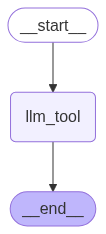

In [28]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

graph = StateGraph(State)
graph.add_node("llm_tool", llm_tool)
graph.add_edge(START, "llm_tool")
graph.add_edge("llm_tool", END)

graph_builder = graph.compile()
display(Image(graph_builder.get_graph().draw_mermaid_png()))

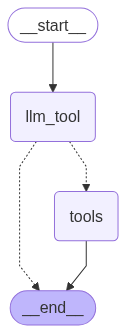

In [29]:
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

tools = [add]

graph = StateGraph(State)
graph.add_node("llm_tool", llm_tool)
graph.add_node("tools", ToolNode(tools))

graph.add_edge(START, "llm_tool")
graph.add_conditional_edges(
    "llm_tool", 
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is not a tool call -> tools_condition routes to END
    tools_condition
)

graph.add_edge("llm_tool", END)
graph.add_edge("tools", END)

graph_builder = graph.compile()
display(Image(graph_builder.get_graph().draw_mermaid_png()))

In [31]:
output_messages = graph_builder.invoke({"messages": "What is 10 + 20?"})

for message in output_messages["messages"]:
    message.pretty_print()

================================ Human Message =================================

What is 10 + 20?
================================== Ai Message ==================================
Tool Calls:
  add (call_IJS0uZoDxE5nLvisSjXg8uJ9)
 Call ID: call_IJS0uZoDxE5nLvisSjXg8uJ9
  Args:
    a: 10
    b: 20
================================= Tool Message =================================
Name: add

30


### Router

A chat model routes between a direct response or a tool call based upon the user input. 

This is a simple example of an agent, where the LLM is directing the control flow either by calling a tool or just responding directly.